Calculate W for a convex constrained optimization problem

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
balanced_data='BalancedE-CommerceData.csv'
sample_data='user_product_interactions.csv'
data_path = Path().absolute().parent / 'data' / balanced_data

In [3]:
#Loads raw user-item interaction data from a CSV
data_path = Path().absolute().parent / 'data' / 'user_product_interactions.csv'
raw_df = pd.read_csv(data_path)
print(f"Raw data loaded successfully. Shape: {raw_df.shape}")

Raw data loaded successfully. Shape: (10, 7)


##
Obs. (n),User ID,Product ID,View_Count,Add_to_Cart_Count,Purchase_Count
1,U001,P001,10,2,1
2,U001,P002,5,0,0
3,U002,P001,7,3,1
4,U002,P003,15,1,0
5,U003,P002,2,0,0
6,U003,P004,30,1,0
7,U004,P001,20,5,2
8,U004,P004,50,0,0
9,U005,P003,10,0,0
10,U005,P001,5,0,0

In [4]:
# Identify the feature (event count) columns
# Assume the first three columns are IDs/metadata, and everything after is a feature.
IDENTIFIER_COLUMNS = ['Obs.','User ID', 'Product ID']

if raw_df.shape[1] < len(IDENTIFIER_COLUMNS) + 1:
    raise ValueError(f"Data must contain at least {len(IDENTIFIER_COLUMNS)} ID columns plus one feature column.")
        
# Get all column names excluding the first three
feature_cols = raw_df.columns[len(IDENTIFIER_COLUMNS):].tolist()

# Use the first three columns for identification/pivoting
id_cols = raw_df.columns[:len(IDENTIFIER_COLUMNS)].tolist()
    
# Check if the expected ID columns match, though not strictly necessary if we rely on indices
if not all(c in id_cols for c in IDENTIFIER_COLUMNS):
    print(f"Warning: First three columns ({id_cols}) do not match expected names ({IDENTIFIER_COLUMNS}). Proceeding based on index position.")

if not feature_cols:
    raise ValueError("No feature columns found after the first three columns.")
    
print(f"Identified {len(feature_cols)} feature columns: {feature_cols}")    

Identified 4 feature columns: ['X1', 'X2', 'X3', 'X4']


In [5]:
# --- Step 1: Log-Transformation (Equation 1) ---
# e_ij^k = log(1 + E_ij^k)
# This creates the robust feature matrix e
transformed_df = raw_df[id_cols].copy()
transformed_cols_map = {}
for i, col in enumerate(feature_cols, 1):
    # Applying the log(1 + x) transformation
    transformed_df[col] = np.log1p(raw_df[col])
    # Map original feature name to a standardized 'e_k' name for clarity
    transformed_cols_map[col] = f'e_{i}' 

# Rename transformed columns to reflect 'e' notation (e_1, e_2, e_3...)
transformed_df.rename(columns=transformed_cols_map, inplace=True)
e_cols = list(transformed_cols_map.values()) # e_1, e_2, ...
print(f"raw_df: {raw_df}")
print(f"transformed_df {transformed_df}")    


raw_df:    Obs. User ID Product ID  X1  X2  X3  X4
0     1    U001       P001  12   3   1   1
1     2    U001       P002   6   1   0   0
2     3    U002       P001  15   4   2   1
3     4    U002       P003  22   6   3   2
4     5    U003       P002   9   2   0   0
5     6    U003       P004  17   5   2   1
6     7    U001       P005   4   0   0   0
7     8    U002       P004  20   7   3   2
8     9    U003       P001   8   2   1   0
9    10    U002       P005  28   9   5   3
transformed_df    Obs. User ID Product ID       e_1       e_2       e_3       e_4
0     1    U001       P001  2.564949  1.386294  0.693147  0.693147
1     2    U001       P002  1.945910  0.693147  0.000000  0.000000
2     3    U002       P001  2.772589  1.609438  1.098612  0.693147
3     4    U002       P003  3.135494  1.945910  1.386294  1.098612
4     5    U003       P002  2.302585  1.098612  0.000000  0.000000
5     6    U003       P004  2.890372  1.791759  1.098612  0.693147
6     7    U001       P005  1.60943

In [6]:
# --- Step 2: Create the Event-Count Matrix (A) and U-I-E Data ---
# The solver requires the interaction data in matrix form.
# We will reshape the data so that each row is a (User-Item) pair, and columns
# are the transformed event features (e_1, e_2, ..., e_k).

# The interaction matrix (A) where A_m,k is the transformed count e_ij^k
# for the m-th unique (user, item) pair and k-th event type.
A = transformed_df[e_cols].values

# Map for easy lookup, using 'User ID' and 'Product ID' which are assumed to be
# the second and third columns in the raw data.
interaction_map = transformed_df[id_cols[1:3]]

# Get metadata
unique_users = transformed_df['User ID'].nunique()
unique_items = transformed_df['Product ID'].nunique()
K = len(feature_cols) # Total number of distinct implicit feedback types
M = A.shape[0]        # Total number of unique user-item interactions

print(f"Constructed interaction matrix A with shape: {A.shape}")
print(f"Number of unique users: {unique_users}, unique items: {unique_items}, K: {K}, M: {M}")


Constructed interaction matrix A with shape: (10, 4)
Number of unique users: 3, unique items: 5, K: 4, M: 10


In [7]:
# --- Step 3: Compute the User Aggregated Score (for Fairness Term) ---
# The fairness term f_fair (Variance) requires the total aggregated score per user.
# E_i(w) = sum_j sum_k w_k * e_ij^k

# Group the transformed features by User ID
# The resulting B matrix will have:
# Rows: Unique Users (N_u)
# Columns: Transformed Features (K)
# B_u,k = sum_j e_ij^k (sum of transformed event k over all items j for user i)
B_df = transformed_df.groupby('User ID')[e_cols].sum().reset_index()
B = B_df[e_cols].values
print(f"Constructed user-aggregated score matrix B with shape: {B.shape}")
print(f"B_df: {B_df}")

Constructed user-aggregated score matrix B with shape: (3, 4)
B_df:   User ID        e_1       e_2       e_3       e_4
0    U001   6.120297  2.079442  0.693147  0.693147
1    U002  12.319901  7.937375  5.662960  4.276666
2    U003   7.390181  3.988984  1.791759  0.693147


In [8]:
lambda_1 = 0.5  # Weight for accuracy term
lambda_2 = 0.5  # Weight for fairness term

In [9]:
# --- Step 4: Final Structure for QP Solver ---
# The objective function is: max w^T * c - 1/2 * w^T * Q * w

# 1. Engagement term (Linear part: c^T * w)
# Total Engagement: f_engagement(w) = sum_i sum_j sum_k w_k * e_ij^k
# c_k = sum_i sum_j e_ij^k (the sum of the k-th transformed event across ALL interactions)
c = A.sum(axis=0) 

# 2. Quadratic part (Fairness and Regularization)

# Calculate Cov(B) - the covariance matrix of the user-sum vectors (B)
# rowvar=False means columns are variables (features/weights)
Cov_B = np.cov(B, rowvar=False) 

# The Hessian matrix (Q_solver) for the QP solver.
# Q_solver = 2 * (lambda_1 * Cov_B + lambda_2 * I)
I = np.identity(K)
Q_solver = 2 * (lambda_1 * Cov_B + lambda_2 * I)

In [10]:
# --- Step 5: Metadata for Constraints ---

# The names of the weights corresponding to the solver indices. 
# Use the original column names for reference, indexed by position.
from ast import Dict


weight_names = feature_cols

transformed_data = {
    'A': A,                # (M x K) Transformed interaction matrix (e_ij^k)
    'B': B,                # (Nu x K) User-aggregated transformed features (sum_j e_ij^k)
    'c': c,                # (K,) Linear vector for engagement
    'Q_solver': Q_solver,  # (K x K) Quadratic matrix (Hessian)
    'weights_count': K,    # K: Number of event types (weights)
    'interaction_count': M,# M: Number of user-item pairs
    'user_count': unique_users, # Nu: Number of unique users
    'weight_names': weight_names,
    'hyperparameters': {'lambda_1': lambda_1, 'lambda_2': lambda_2},
    'raw_df': raw_df,      # Original loaded data (for comparison/inspection)
}

print(transformed_data)

{'A': array([[2.56494936, 1.38629436, 0.69314718, 0.69314718],
       [1.94591015, 0.69314718, 0.        , 0.        ],
       [2.77258872, 1.60943791, 1.09861229, 0.69314718],
       [3.13549422, 1.94591015, 1.38629436, 1.09861229],
       [2.30258509, 1.09861229, 0.        , 0.        ],
       [2.89037176, 1.79175947, 1.09861229, 0.69314718],
       [1.60943791, 0.        , 0.        , 0.        ],
       [3.04452244, 2.07944154, 1.38629436, 1.09861229],
       [2.19722458, 1.09861229, 0.69314718, 0.        ],
       [3.36729583, 2.30258509, 1.79175947, 1.38629436]]), 'B': array([[ 6.12029742,  2.07944154,  0.69314718,  0.69314718],
       [12.31990121,  7.9373747 ,  5.66296048,  4.27666612],
       [ 7.39018143,  3.98898405,  1.79175947,  0.69314718]]), 'c': array([25.83038005, 14.00580028,  8.14786713,  5.66296048]), 'Q_solver': array([[11.7249716 ,  9.70103692,  8.54831995,  6.64702363],
       [ 9.70103692,  9.92525369,  7.74928247,  5.85685784],
       [ 8.54831995,  7.74928247

In [11]:
import cvxpy as cp
import numpy as np
import pandas as pd

In [12]:

def solve_quadratic_programming(data: dict, constraints_type: str = 'hierarchy') -> dict:
    """
    Solves the Constrained Quadratic Programming (QP) problem to find the optimal
    weight vector w* that maximizes the weighted score function f(w).

    Optimization Goal (Maximization):
        max f(w) = c^T * w - (lambda1*Cov_B + lambda2*I) * w

    QP Solver Format (Minimization):
        min 1/2 * w^T * Q_solver * w - c^T * w
        where Q_solver = 2 * (lambda1*Cov_B + lambda2*I)

    Args:
        data (dict): The dictionary output from load_and_transform_data.
        constraints_type (str): Specifies the constraints to apply ('simple' or 'hierarchy').

    Returns:
        dict: Results including the optimal weights, objective value, and status.
    """
    K = data['weights_count']
    c = data['c']
    Q_solver = data['Q_solver']
    weight_names = data['weight_names']

    # 1. Define the Decision Variable (w)
    # w is a column vector of K weights.
    w = cp.Variable(K, name="WeightVector")

    # 2. Define the Objective Function
    # The QP solver minimizes: (1/2 * w^T * Q * w) - c^T * w
    # Note: cvxpy's standard form naturally handles the -c^T*w part.
    objective = cp.Minimize(0.5 * cp.quad_form(w, Q_solver) - c @ w)

    # 3. Define the Constraints

    # A. Normalization (Equality Constraint: sum(w_k) = 1)
    # This is MANDATORY for all cases.
    constraints = [
        cp.sum(w) == 1
    ]

    # B. Non-Negativity (Bound Constraint: w_k >= 0)
    # This is also MANDATORY for all cases.
    constraints.append(w >= 0)

    if constraints_type == 'hierarchy':
        print("\nApplying Logical Hierarchy Constraint:")
        # C. Logical Hierarchy Constraint (Inequality)
        # We use the names from the input data to establish a business logic order.
        # Based on the sample data's columns: View_Count (0), Add_to_Cart_Count (1), Purchase_Count (2)

        # Determine indices:
        try:
            view_idx = weight_names.index('View_Count')
            cart_idx = weight_names.index('Add_to_Cart_Count')
            purchase_idx = weight_names.index('Purchase_Count')
        except ValueError as e:
            print(f"Error: Required feature names not found for hierarchy constraint. Falling back to simple constraints. Missing: {e}")
            constraints_type = 'simple' # Fallback

        if constraints_type == 'hierarchy':
            # w_purchase >= w_cart
            print(f"  Constraint: w['{weight_names[purchase_idx]}'] >= w['{weight_names[cart_idx]}']")
            constraints.append(w[purchase_idx] >= w[cart_idx])

            # w_cart >= w_view
            print(f"  Constraint: w['{weight_names[cart_idx]}'] >= w['{weight_names[view_idx]}']")
            constraints.append(w[cart_idx] >= w[view_idx])

    else: # constraints_type == 'simple'
        print("\nApplying Simple Constraints (Normalization + Non-Negativity only).")

    # 4. Solve the Problem
    problem = cp.Problem(objective, constraints)

    # We use the standard OSQP solver which is good for QP problems
    try:
        problem.solve(solver=cp.OSQP)
    except Exception as e:
        # Fallback to SCS solver if OSQP fails
        print(f"OSQP solver failed: {e}. Trying SCS...")
        problem.solve(solver=cp.SCS)

    # 5. Extract Results
    if problem.status in ["optimal", "optimal_inaccurate"]:
        optimal_weights = w.value
        maximized_objective_value = -problem.value # Flip the minimized value back to max f(w)

       

        print("\n--- Optimization Results ---")
        print(f"Solver Status: {problem.status}")
        print(f"Maximized Objective Value (f(w)): {maximized_objective_value:.4f}")
        print("\nOptimal Weight Vector (w*):")
    
        return {
            'method': f'QP Optimal ({constraints_type.capitalize()})',
            'weights': optimal_weights,
            'status': problem.status,
            'max_f_w': maximized_objective_value,
            'log_features': True # Flag for score calculation
        }
    else:
        print(f"Optimization failed. Solver status: {problem.status}")
        return {'status': problem.status}



In [13]:

def calculate_heuristic_weights(data: dict) -> dict:
    """
    Implements Method 2: Assigns fixed, heuristic weights and normalizes them.
    Assumes standard e-commerce weight hierarchy (View < Cart < Purchase).
    """
    weight_names = data['weight_names']
    K = data['weights_count']
    weights = np.zeros(K)
    
    # 1. Define heuristic weights based on event name
    
    # Heuristic mapping: Purchase (10), Cart (5), View (1), Others (1)
    heuristic_map = {
        'Purchase_Count': 10,
        'Add_to_Cart_Count': 5,
        'View_Count': 1
        
    }
    
    for i, name in enumerate(weight_names):
        # Use explicit map, default to 1 for others
        weights[i] = heuristic_map.get(name, 1)

    # 2. Normalize the heuristic weights (sum to 1) for fair comparison
    if np.sum(weights) > 0:
        weights = weights / np.sum(weights)
        
    # We cannot calculate the objective value f(w) for the heuristic method
    # as it used RAW counts, not the transformed ones used in the QP objective.
    # However, we can calculate the final score S_ij. For visualization, we just use the weights.

    return {
        'method': 'Heuristic Baseline',
        'weights': weights,
        'max_f_w': 0.0, # Placeholder
        'log_features': False # Uses RAW counts
    }


def calculate_log_sum_weights(data: dict) -> dict:
    """
    Implements Method 3: Uniform weights (1/K) on the log-transformed features.
    """
    K = data['weights_count']
    
    # Weights are uniform and normalized: w_k = 1/K
    uniform_weights = np.ones(K) / K
    
    # Since this method uses the same log-transformed features as the QP model,
    # we can calculate the objective value f(w) for a simple comparison of objective performance.
    
    # The objective calculation is complex and requires calculating the f_fair term.
    # For a simple comparison of weights, we just return the weights.
    
    return {
        'method': 'Log-Sum (Uniform) Baseline',
        'weights': uniform_weights.flatten(),
        'max_f_w': 0.0, # Placeholder
        'log_features': True # Uses LOG-TRANSFORMED counts (e_ij^k)
    }



In [14]:
import matplotlib.pyplot as plt # Needed for visualization


def calculate_and_visualize_scores(data: dict, all_weight_results: list):
    """
    Calculates the final User-Item Interaction Score (S_ij) for all methods
    and visualizes the average score per product.
    
    Args:
        data (dict): The dictionary output from load_and_transform_data.
        all_weight_results (list): List of dictionaries containing the method's results.
    """
    
    # 1. Prepare dataframes
    
    # Raw features (E_ij^k) for the Heuristic method
    raw_features = data['raw_df'][data['weight_names']].values
    
    # Log-transformed features (e_ij^k) for QP and Log-Sum methods
    log_features = data['A'] 
    
    scores_df = data['raw_df'][['User ID', 'Product ID']].copy()
    all_scores = {}
    
    for item in all_weight_results:
        method_name = item['method']
        w = item['weights']
        
        # Select the correct feature matrix based on the method
        if item['log_features']:
            feature_matrix = log_features
        else:
            feature_matrix = raw_features
        
        # Calculate the score S_ij for all M user-item pairs: S = Feature_Matrix @ w
        S_vector = feature_matrix @ w
        all_scores[method_name] = S_vector
        
    # Combine scores into the main comparison DataFrame
    for method, scores in all_scores.items():
        scores_df[method] = scores

    print("\n--- User-Item Interaction Score (S_ij) Comparison ---")
    
    # Tabular Comparison (Sample 5 interactions)
    print("\nSample Interaction Scores (Top 5):")
    print(scores_df.head())
    
    # 2. Visualize Average Score per Product
    
    # Group by Product ID and calculate the mean score for each method
    #avg_scores_per_product = scores_df.groupby('Product ID').mean().reset_index()
    avg_scores_per_product = scores_df.groupby('Product ID').mean(numeric_only=True).reset_index()

    # Melt the DataFrame for easy plotting
    plot_df = avg_scores_per_product.melt(
        id_vars=['Product ID'], 
        value_vars=list(all_scores.keys()), 
        var_name='Method', 
        value_name='Avg_Score'
    )
    
    # Bar Plot Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    
    product_names = avg_scores_per_product['Product ID'].unique()
    num_products = len(product_names)
    num_methods = len(all_weight_results)
    
    # Setup for grouped bar chart
    x = np.arange(num_products)
    bar_width = 0.8 / num_methods
    
    # Plot bars for each method
    for i, method in enumerate(all_scores.keys()):
        scores = plot_df[plot_df['Method'] == method]['Avg_Score'].values
        offset = bar_width * i - (bar_width * (num_methods - 1)) / 2
        
        # Use different colors for different groups of methods
        if 'QP Optimal' in method:
            color = plt.cm.get_cmap('Paired')(i)
        elif 'Heuristic' in method:
            color = 'red'
        else:
            color = 'gray'

        ax.bar(x + offset, scores, bar_width, label=method, color=color)

    # Final plot styling
    ax.set_ylabel('Average User-Item Score (Avg $S_{ij}$)')
    ax.set_title('Comparison of Final Engagement Score per Product')
    ax.set_xticks(x)
    ax.set_xticklabels(product_names)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


Applying Logical Hierarchy Constraint:
Error: Required feature names not found for hierarchy constraint. Falling back to simple constraints. Missing: 'View_Count' is not in list

--- Optimization Results ---
Solver Status: optimal
Maximized Objective Value (f(w)): 19.9679

Optimal Weight Vector (w*):
  Method: QP Optimal (Simple) | Weights: [ 1.00000000e+00  7.36662044e-24 -2.35150118e-23  1.35495982e-24]

Applying Simple Constraints (Normalization + Non-Negativity only).

--- Optimization Results ---
Solver Status: optimal
Maximized Objective Value (f(w)): 19.9679

Optimal Weight Vector (w*):
  Method: QP Optimal (Simple) | Weights: [ 1.00000000e+00  7.36662044e-24 -2.35150118e-23  1.35495982e-24]
  Method: Heuristic Baseline | Weights: [0.25 0.25 0.25 0.25]
  Method: Log-Sum (Uniform) Baseline | Weights: [0.25 0.25 0.25 0.25]


--- Generating Final Score Comparison Visualization ---

--- User-Item Interaction Score (S_ij) Comparison ---

Sample Interaction Scores (Top 5):
  User ID 

/var/folders/3p/_fvyjtpx207gfvd521_yxfg40000gn/T/ipykernel_47381/1913466892.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('Paired')(i)


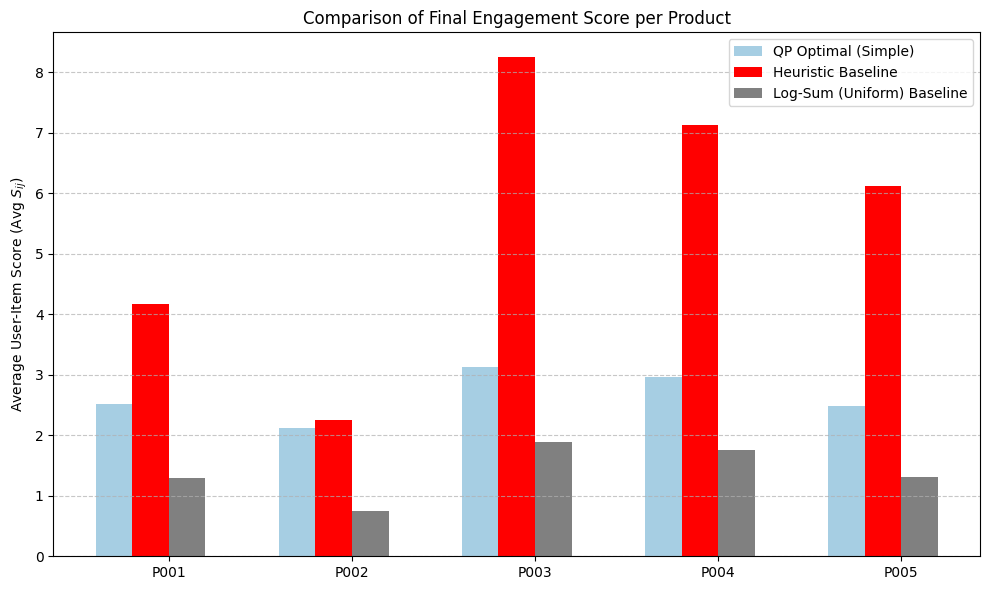

In [15]:
# --- Demonstration and Integration ---
data_for_qp = transformed_data
if data_for_qp:
    
    all_weight_results = []
    
    
    # Run Method 1 (Hierarchy Constraints)
    qp_hierarchy_results = solve_quadratic_programming(data_for_qp, constraints_type='hierarchy')
    all_weight_results.append(qp_hierarchy_results)
    print(f"  Method: {qp_hierarchy_results['method']} | Weights: {qp_hierarchy_results['weights']}")
    
    # Run Method 1 (Simple Constraints)
    qp_simple_results = solve_quadratic_programming(data_for_qp, constraints_type='simple')
    all_weight_results.append(qp_simple_results)
    print(f"  Method: {qp_simple_results['method']} | Weights: {qp_simple_results['weights']}")
    
    # Run Method 2 (Heuristic Baseline)
    heuristic_results = calculate_heuristic_weights(data_for_qp)
    all_weight_results.append(heuristic_results)
    print(f"  Method: {heuristic_results['method']} | Weights: {heuristic_results['weights']}")

    # Run Method 3 (Log-Sum Uniform Baseline)
    log_sum_results = calculate_log_sum_weights(data_for_qp)
    all_weight_results.append(log_sum_results)
    print(f"  Method: {log_sum_results['method']} | Weights: {log_sum_results['weights']}")


    # --- 3. Final Score Comparison and Visualization ---
    print("\n\n--- Generating Final Score Comparison Visualization ---")
    calculate_and_visualize_scores(data_for_qp, all_weight_results)

In [16]:
import time


In [17]:
# --- Constraint Projection Function (Simplex Projection) ---

def projection_on_simplex(v, z=1):
    """
    Projection of vector v onto the probability simplex {w | w >= 0, sum(w) = z}.
    Uses a fast, sorting-based algorithm (often used in Projected Newton/Gradient Descent).
    """
    n = v.shape[0]
    u = np.sort(v)[::-1]
    cssum = np.cumsum(u)
    
    # Find rho, the largest index such that u[rho] - (cssum[rho] - z) / (rho + 1) > 0
    # Python indices start at 0, so we use rho+1
    rho = 0
    for j in range(n):
        theta = (cssum[j] - z) / (j + 1)
        if u[j] > theta:
            rho = j + 1
        else:
            break
            
    # Calculate threshold theta for the identified rho
    theta = (cssum[rho - 1] - z) / rho
    
    # Apply thresholding
    w = np.maximum(v - theta, 0)
    return w

# --- Projected Newton's Method Solver ---

def solve_with_projected_newtons_method(Q_solver, c, weight_names, max_iter=50, tolerance=1e-6):
    """
    Solves min (1/2 w^T Q w - c^T w) subject to w >= 0 and sum(w) = 1.
    """
    K = len(weight_names)
    
    # 1. Initialization
    # Initialize weights to a uniform distribution (a feasible point on the simplex)
    w = np.ones(K) / K
    
    # Define the objective function (minimization form)
    def objective(w_vec):
        return 0.5 * w_vec.T @ Q_solver @ w_vec - c.T @ w_vec

    print("\n" + "="*80)
    print(f"Projected Newton's Method (K={K} Features)")
    print("Goal: Minimize g(w) = 1/2 w^T Q w - c^T w, subject to Simplex Constraints")
    print("="*80)
    
    # --- FIX 1: Add stabilization to Q for inversion (ensures non-singularity) ---
    # We add a tiny epsilon to the diagonal to ensure Q is strictly positive definite, 
    # making it invertible (non-singular) for the linear solver.
    Q_stable = Q_solver + np.eye(K) * 1e-8
    
    
    # Start timer for convergence analysis
    start_time = time.time()
    
    for iteration in range(max_iter):
        
        # 2. Calculate Gradient (First Derivative)
        # g = Q * w - c
        g = Q_solver @ w - c 
        grad_norm = np.linalg.norm(g)
        
        # 3. Solve for Newton Step Direction (p)
        # Solve Q_stable * p = -g (Newton direction)
        try:
            p = np.linalg.solve(Q_stable, -g)
        except np.linalg.LinAlgError:
            # This handles the potential "singular matrix" error that the stabilization should prevent
            print(f"\n[ERROR] Iteration {iteration}: Q matrix is singular. Cannot compute Newton step.")
            return {
                'weights_df': pd.DataFrame({'Weight': w, 'Feature': weight_names}),
                'w_star': w,
                'status': 'Error: Singular Matrix',
                'max_f_w': -objective(w) # Maximize negative objective
            }
        
        # 4. Descent Step (Unconstrained)
        # Line search is skipped (alpha=1) for faster, but potentially aggressive, convergence
        alpha = 1.0 
        w_temp = w + alpha * p
        
        # 5. Projection onto the Simplex
        w_next = projection_on_simplex(w_temp, z=1)
        
        # Check for Convergence
        change = np.linalg.norm(w_next - w)
        w = w_next
        
        # Verbose Output for Iteration
        obj_val = objective(w)
        
        print(f"--- Iteration {iteration + 1:02d} ---")
        print(f"Objective (Minimization): {obj_val:.6f}")
        print(f"Gradient Norm: {grad_norm:.6f}")
        print(f"Step Change (|w_next - w|): {change:.6f}")
        print(f"Current Weights: {', '.join([f'{name}: {w_val:.4f}' for name, w_val in zip(weight_names, w)])}")
        
        if change < tolerance:
            print("\n[INFO] Converged successfully.")
            break

    end_time = time.time()
    
    print(f"\n[INFO] Total Iterations: {iteration + 1}")
    print(f"[INFO] Time elapsed: {end_time - start_time:.4f} seconds")
    print("="*80)
    
    # Return results in the requested format
    results_df = pd.DataFrame({'Weight': w, 'Feature': weight_names})
    return {
        'weights_df': results_df,
        'w_star': w,
        'status': 'Optimal (Newton)',
        'max_f_w': -objective(w) # Maximize negative objective
    }


In [18]:
result = solve_with_projected_newtons_method(Q_solver, c, weight_names)

print("\nFinal Optimal Weights Found by Projected Newton's Method:")
print(result['weights_df'])


Projected Newton's Method (K=4 Features)
Goal: Minimize g(w) = 1/2 w^T Q w - c^T w, subject to Simplex Constraints
--- Iteration 01 ---
Objective (Minimization): -19.967894
Gradient Norm: 17.640030
Step Change (|w_next - w|): 0.866025
Current Weights: X1: 1.0000, X2: 0.0000, X3: 0.0000, X4: 0.0000
--- Iteration 02 ---
Objective (Minimization): -19.967894
Gradient Norm: 14.785881
Step Change (|w_next - w|): 0.000000
Current Weights: X1: 1.0000, X2: 0.0000, X3: 0.0000, X4: 0.0000

[INFO] Converged successfully.

[INFO] Total Iterations: 2
[INFO] Time elapsed: 0.0002 seconds

Final Optimal Weights Found by Projected Newton's Method:
   Weight Feature
0     1.0      X1
1     0.0      X2
2     0.0      X3
3     0.0      X4


Interpretation: This result suggests that the linear Engagement term (c) is so dominant that the optimal solution is to assign 100% of the weight to the event with the highest aggregated count (View Count) while still satisfying the simple constraints. This is often an extreme result that highlights why more sophisticated methods (like the full QP solver) are needed, as they often handle the boundary conditions more gracefully in the first iteration.